In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

In [2]:
def load_and_clean(file_path):
    df = (
        pd.read_csv(file_path, usecols=['Date', 'Dernier'], decimal=',', thousands=' ')
        .assign(Date=lambda x: pd.to_datetime(x['Date'], dayfirst=True),
                Dernier=lambda x: pd.to_numeric(x['Dernier'], errors='coerce'))
        .dropna()
        .sort_values('Date')
    )
    df['Dernier'] = df['Dernier'].replace(0, np.nan).interpolate()
    df = df.dropna()
    return df

In [3]:
dataEdf = load_and_clean('C:/Users/loren/Downloads/EDF10.csv')
dataOAT = load_and_clean('C:/Users/loren/Downloads/OAT10.csv')

In [4]:
df = pd.merge(
    dataEdf.rename(columns={'Dernier': 'EDF_10ans'}),
    dataOAT.rename(columns={'Dernier': 'OAT_10ans'}),
    on='Date',
    how='inner'
)

In [6]:
def local_mean_rule(data):
    cleaned = data.copy()
    n = len(cleaned)
    for i in range(n):
        if cleaned[i] < 0:
            up = cleaned[i-1] if i>0 and cleaned[i-1] >= 0 else None
            down = cleaned[i+1] if i<n-1 and cleaned[i+1] >= 0 else None
            if up is not None and down is not None:
                cleaned[i] = (up + down)/2
            elif up is not None:
                cleaned[i] = up
            elif down is not None:
                cleaned[i] = down
    return cleaned

cleaned_values = local_mean_rule(df['OAT_10ans'].values)
df['OAT_10ans'] = cleaned_values

In [7]:
df['logret_OAT'] = np.log(df['OAT_10ans'] / df['OAT_10ans'].shift(1))
df['logret_EDF'] = np.log(df['EDF_10ans'] / df['EDF_10ans'].shift(1))
df = df.dropna()

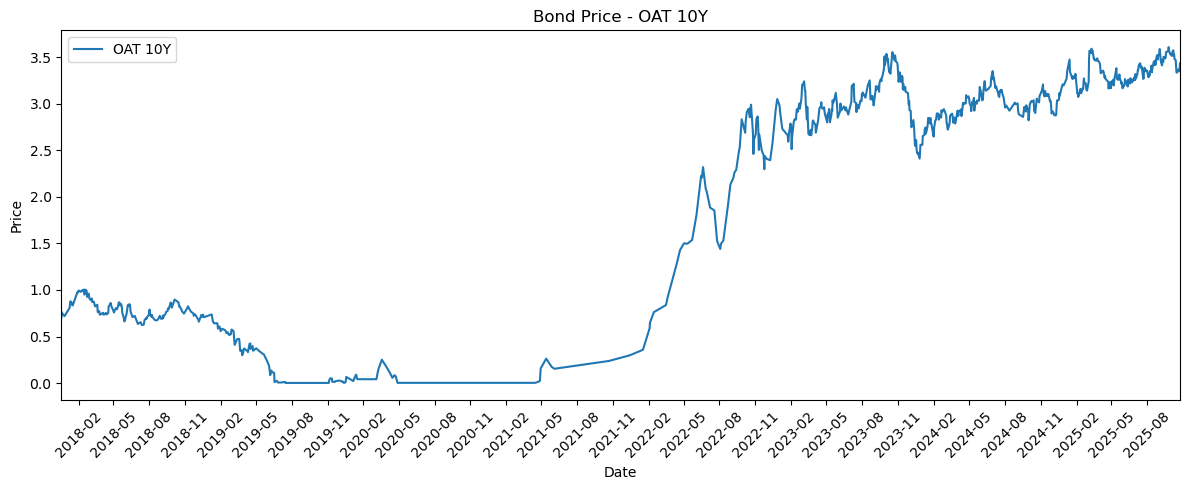

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['OAT_10ans'], label='OAT 10Y')

plt.title("Bond Price - OAT 10Y")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df['Date'].min(), df['Date'].max())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

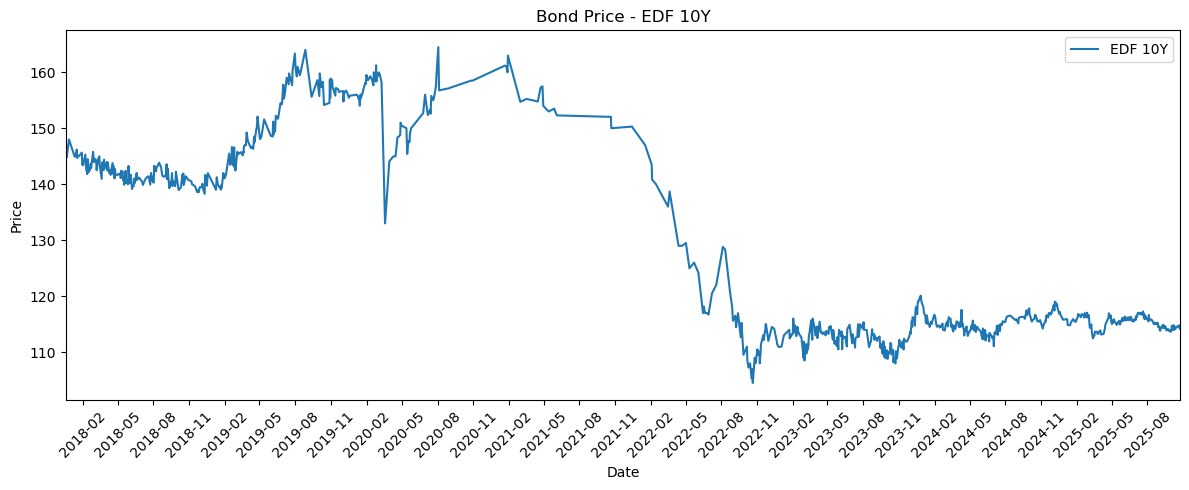

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['EDF_10ans'], label='EDF 10Y')

plt.title("Bond Price - EDF 10Y")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df['Date'].min(), df['Date'].max())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['logret_OAT'], label='OAT 10Y')

plt.title("LogReturn- OAT 10Y")
plt.xlabel("Date")
plt.ylabel("LogReturn")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df['Date'].min(), df['Date'].max())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['logret_EDF'], label='OAT 10Y')

plt.title("LogReturn- EDF 10Y")
plt.xlabel("Date")
plt.ylabel("LogReturn")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df['Date'].min(), df['Date'].max())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
OATtest = df['logret_OAT']
result = adfuller(OATtest)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

plot_acf(OATtest, lags=10)
plot_pacf(OATtest, lags=10)
plt.show()

max_p = 2
max_q = 2
results = {}

In [ ]:
for p in range(3):
    for q in range(3):
        if p == 0 and q == 0:
            continue
        result = ARIMA(OATtest, order=(p, 0, q)).fit()
        print(result.summary())

In [ ]:
EDFtest = df['logret_EDF']
result = adfuller(EDFtest)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

plot_acf(EDFtest, lags=10)
plot_pacf(EDFtest, lags=10)
plt.show()

max_p = 2
max_q = 2
results = {}

In [ ]:
for p in range(3):
    for q in range(3):
        if p == 0 and q == 0:
            continue
        result = ARIMA(EDFtest, order=(p, 0, q)).fit()
        print(result.summary())

In [ ]:
warnings.filterwarnings("default")

In [ ]:
from statsmodels.tsa.api import VAR

dflogret = pd.DataFrame({'logret_OAT': OATtest, 'logret_EDF': EDFtest})
results = VAR(dflogret).fit(maxlags=5, ic='aic')
print(results.summary())

In [ ]:
X = sm.add_constant(df['EDF_10ans'])
model = sm.OLS(df['OAT_10ans'], X).fit()
residuals = model.resid

plt.figure(figsize=(12,5))
plt.plot(residuals, label='Résidu de la cointégration')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.title("Résidu (spread cointégré) entre OAT et EDF")
plt.show()

In [ ]:
X = sm.add_constant(df['OAT_10ans'])
model = sm.OLS(df['EDF_10ans'], X).fit()
beta = model.params.iloc[1]
spread = df['EDF_10ans'] - beta * df['OAT_10ans']
spread = spread/10000
print("Résultats de la régression EDF = α + β×OAT + ε")
print("="*50)
print(model.summary())
print("\nCoefficient beta (pente) :", beta)
print("Constante (alpha) :", model.params.iloc[0])
print("R² :", model.rsquared)

In [ ]:
spread_model = sm.tsa.ARIMA(spread, order=(1, 0, 0)).fit()
result = adfuller(spread)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

In [ ]:
residuals = spread_model.resid.dropna()
result_resid = adfuller(residuals)
print("ADF Statistic (résidus):", result_resid[0])
print("p-value (résidus):", result_resid[1])
print('Critical Values:')
for key, value in result_resid[4].items():
    print(f'{key}: {value}')

In [ ]:
mu = spread_model.params['const']
phi = spread_model.params['ar.L1']
sigma = np.sqrt(spread_model.params['sigma2'])

In [ ]:
n_paths = 10000
T = 12
dt = 1

mc = np.zeros((n_paths, T + 1))
mc[:,0] = spread.iloc[-1]

for t in range(T):
    mc[:,t+1] = mu + phi * (mc[:,t]-mu) + np.random.normal(0, sigma, n_paths)

In [ ]:
# Tracé des simulations
plt.figure(figsize=(12, 6))

for i in range(50):
    plt.plot(mc[i, :], color='skyblue', alpha=0.4, label='Simulations' if i == 0 else "")

plt.title(f"Simulations Monte Carlo du spread sur {T} périodes")
plt.xlabel("Périodes futures")
plt.ylabel("Valeur du spread")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
freq = 12
T_years = T / freq

# Testez avec différents taux d'actualisation
rates = [0.01, 0.02, 0.03]
for r in rates:
    discount_factors = 1 / (1 + r/freq) ** np.arange(1, T+1)
    PV = np.mean(mc[:, 1:T+1] @ discount_factors)
    print(f"Taux {r*100}% - Valeur: {PV:.6f}")

In [ ]:
plt.hist(np.sum(mc[:, 1:T+1] * discount_factors, axis=1), bins=50)
mean_value = np.mean(np.sum(mc[:, 1:T+1] * discount_factors, axis=1))
plt.axvline(x=mean_value, color='r', linestyle='--')
plt.title('Distribution des valeurs actuelles simulées')
plt.show()